In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [2]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation'

In [3]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [4]:
pixels = 256

In [5]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [6]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [7]:
def binarize(img):
    img[img>0] = 1
    return img

In [8]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [9]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

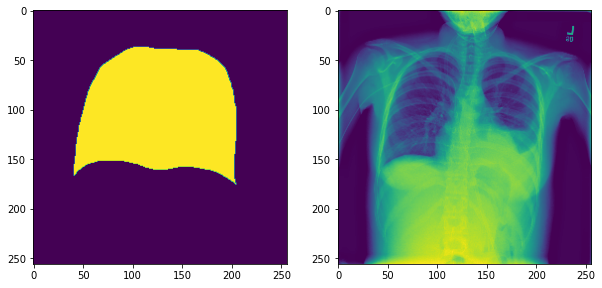

In [10]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [11]:
images.shape

(300, 256, 256, 1)

# Aumento de datos

In [12]:
import imutils

In [13]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    return input_image, input_mask

Nuevas imagenes con rotacion random

In [14]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [15]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
# importance = np.concatenate((importance, importance), axis=0)

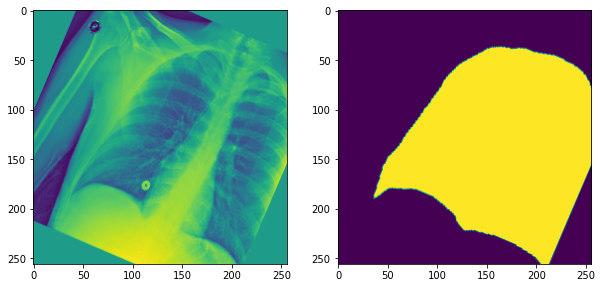

In [16]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [17]:
images.shape

(600, 256, 256, 1)

In [18]:
masks.shape

(600, 256, 256, 1)

# U-Net

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [21]:
def double_conv_block(x, n_filters):
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with eLU activation
    x = double_conv_block(x, n_filters)
    return x

In [22]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(pixels,pixels,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [23]:
unet_model = build_unet_model()

In [24]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [25]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + 'U-Net1_3chanel_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience = 10)

In [26]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy", "mean_squared_error"])

In [27]:
batch = 8
epoch = 500

In [28]:
history = unet_model.fit(images,masks,
                         batch_size = batch,
                         epochs = epoch,
                         callbacks = [tensorboard_callback, early_stop],
                         # sample_weight = importance,
                         shuffle = True,
                         verbose = 2,
                         validation_split = 0.2)

Epoch 1/500
60/60 - 66s - loss: 2.0864 - accuracy: 0.6027 - mean_squared_error: 0.3704 - val_loss: 0.5428 - val_accuracy: 0.7109 - val_mean_squared_error: 0.3421
Epoch 2/500
60/60 - 19s - loss: 0.4991 - accuracy: 0.7461 - mean_squared_error: 0.3680 - val_loss: 0.3935 - val_accuracy: 0.8185 - val_mean_squared_error: 0.3685
Epoch 3/500
60/60 - 18s - loss: 0.3603 - accuracy: 0.8396 - mean_squared_error: 0.3912 - val_loss: 0.3445 - val_accuracy: 0.8499 - val_mean_squared_error: 0.3977
Epoch 4/500
60/60 - 19s - loss: 0.3224 - accuracy: 0.8624 - mean_squared_error: 0.4009 - val_loss: 0.2785 - val_accuracy: 0.8895 - val_mean_squared_error: 0.4026
Epoch 5/500
60/60 - 19s - loss: 0.2790 - accuracy: 0.8828 - mean_squared_error: 0.4074 - val_loss: 0.2208 - val_accuracy: 0.9136 - val_mean_squared_error: 0.4088
Epoch 6/500
60/60 - 19s - loss: 0.2355 - accuracy: 0.9020 - mean_squared_error: 0.4166 - val_loss: 0.1881 - val_accuracy: 0.9244 - val_mean_squared_error: 0.4238
Epoch 7/500
60/60 - 19s - lo

# Validación

In [29]:
path = '/home/mr1142/Documents/Data/NIH/images_005'

In [30]:
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

In [49]:
def apply_mask(img, mask):
    mask = mask[...,1]
    mask = cv2.blur(mask, (5,5))
    mask[mask>0.3]=1
    img[mask!=1]=0
    return img

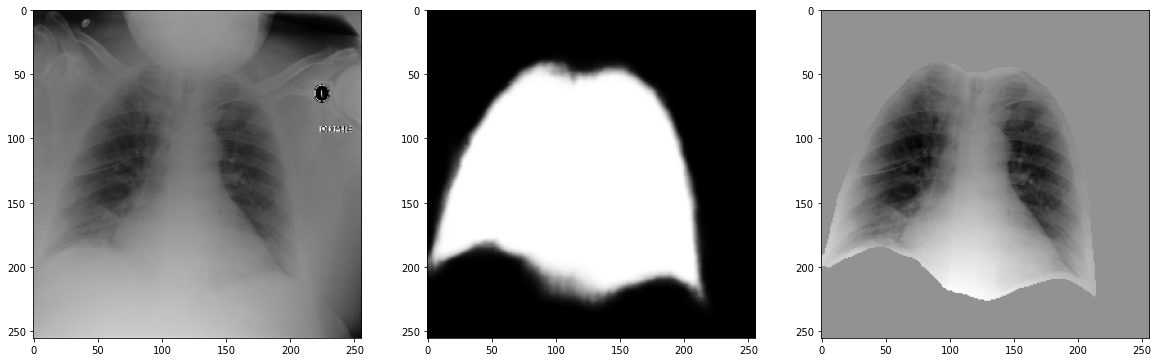

In [82]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask[...,1], cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

In [33]:
unet_model.save('/home/mr1142/Documents/Data/models/unet_3chanels.h5')